In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os

# Append the parent directory to the Python path
sys.path.append(os.path.abspath(".."))

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.model_selection import train_test_split
from scripts.gradient_descent import CustomLinearRegression


from scripts.utils import (
    load_kaggle_df, 
    load_starting_df, 
    create_submission_csv, 
    X_cols_universal, 
    y_cols_universal, 
    save_model
)

from scripts.models import ( 
    create_baseline_model,
)
from scripts.evaluation import (
    cMSE_error,
    gradient_cMSE_error, 
    compare_models
)
from scripts.plots import plot_y_yhat

startingDF = load_starting_df()
kaggleDF = load_kaggle_df()

## Task 1 - Setting the baseline

Just like we did in the previous assignment, our first step will be to set a baseline. This task envolves the use of regression and we will fit as a baseline a Linear Regression model that we can use to compare with further model developments.

### Task 1.1 - Data preparation and Validation pipeline

In [3]:
startingDF.head()

,ID,Age,Gender,Stage,GeneticRisk,TreatmentType,ComorbidityIndex,TreatmentResponse,SurvivalTime,Censored
0,0,65.0,0,2,1.0,0,0.0,0.0,4.2,0
1,1,68.0,1,2,0.0,1,1.0,1.0,4.7,1
2,2,68.0,1,3,1.0,1,0.0,1.0,3.5,1
3,3,81.0,1,4,1.0,1,3.0,0.0,2.3,0
4,4,59.0,1,2,1.0,0,NaN,0.0,NaN,0


In [4]:
startingDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 400 non-null    int64  
 1   Age                400 non-null    float64
 2   Gender             400 non-null    int64  
 3   Stage              400 non-null    int64  
 4   GeneticRisk        315 non-null    float64
 5   TreatmentType      400 non-null    int64  
 6   ComorbidityIndex   355 non-null    float64
 7   TreatmentResponse  371 non-null    float64
 8   SurvivalTime       240 non-null    float64
 9   Censored           400 non-null    int64  
dtypes: float64(5), int64(5)
memory usage: 31.4 KB


In [5]:
startingDF.describe()

,ID,Age,Gender,Stage,GeneticRisk,TreatmentType,ComorbidityIndex,TreatmentResponse,SurvivalTime,Censored
count,400.000000,400.00000,400.000000,400.000000,315.000000,400.000000,355.000000,371.000000,240.000000,400.000000
mean,199.500000,65.14250,0.590000,2.565000,0.285714,0.412500,1.092958,0.514825,4.479583,0.197500
std,115.614301,9.55434,0.492449,1.081063,0.452473,0.492901,0.869983,0.500455,2.015370,0.398611
min,0.000000,40.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000
25%,99.750000,59.00000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000
50%,199.500000,65.00000,1.000000,2.500000,0.000000,0.000000,1.000000,1.000000,4.100000,0.000000
75%,299.250000,72.00000,1.000000,4.000000,1.000000,1.000000,2.000000,1.000000,5.700000,0.000000
max,399.000000,90.00000,1.000000,4.000000,1.000000,1.000000,3.000000,1.000000,12.100000,1.000000


From a first inspection, we can observe that we have 400 patients, some with missing that. We start by renaming the first column as ID

In [6]:
startingDF = startingDF.rename(columns={"Unnamed: 0":"ID"})

Bar plots of the missing values

<Axes: >

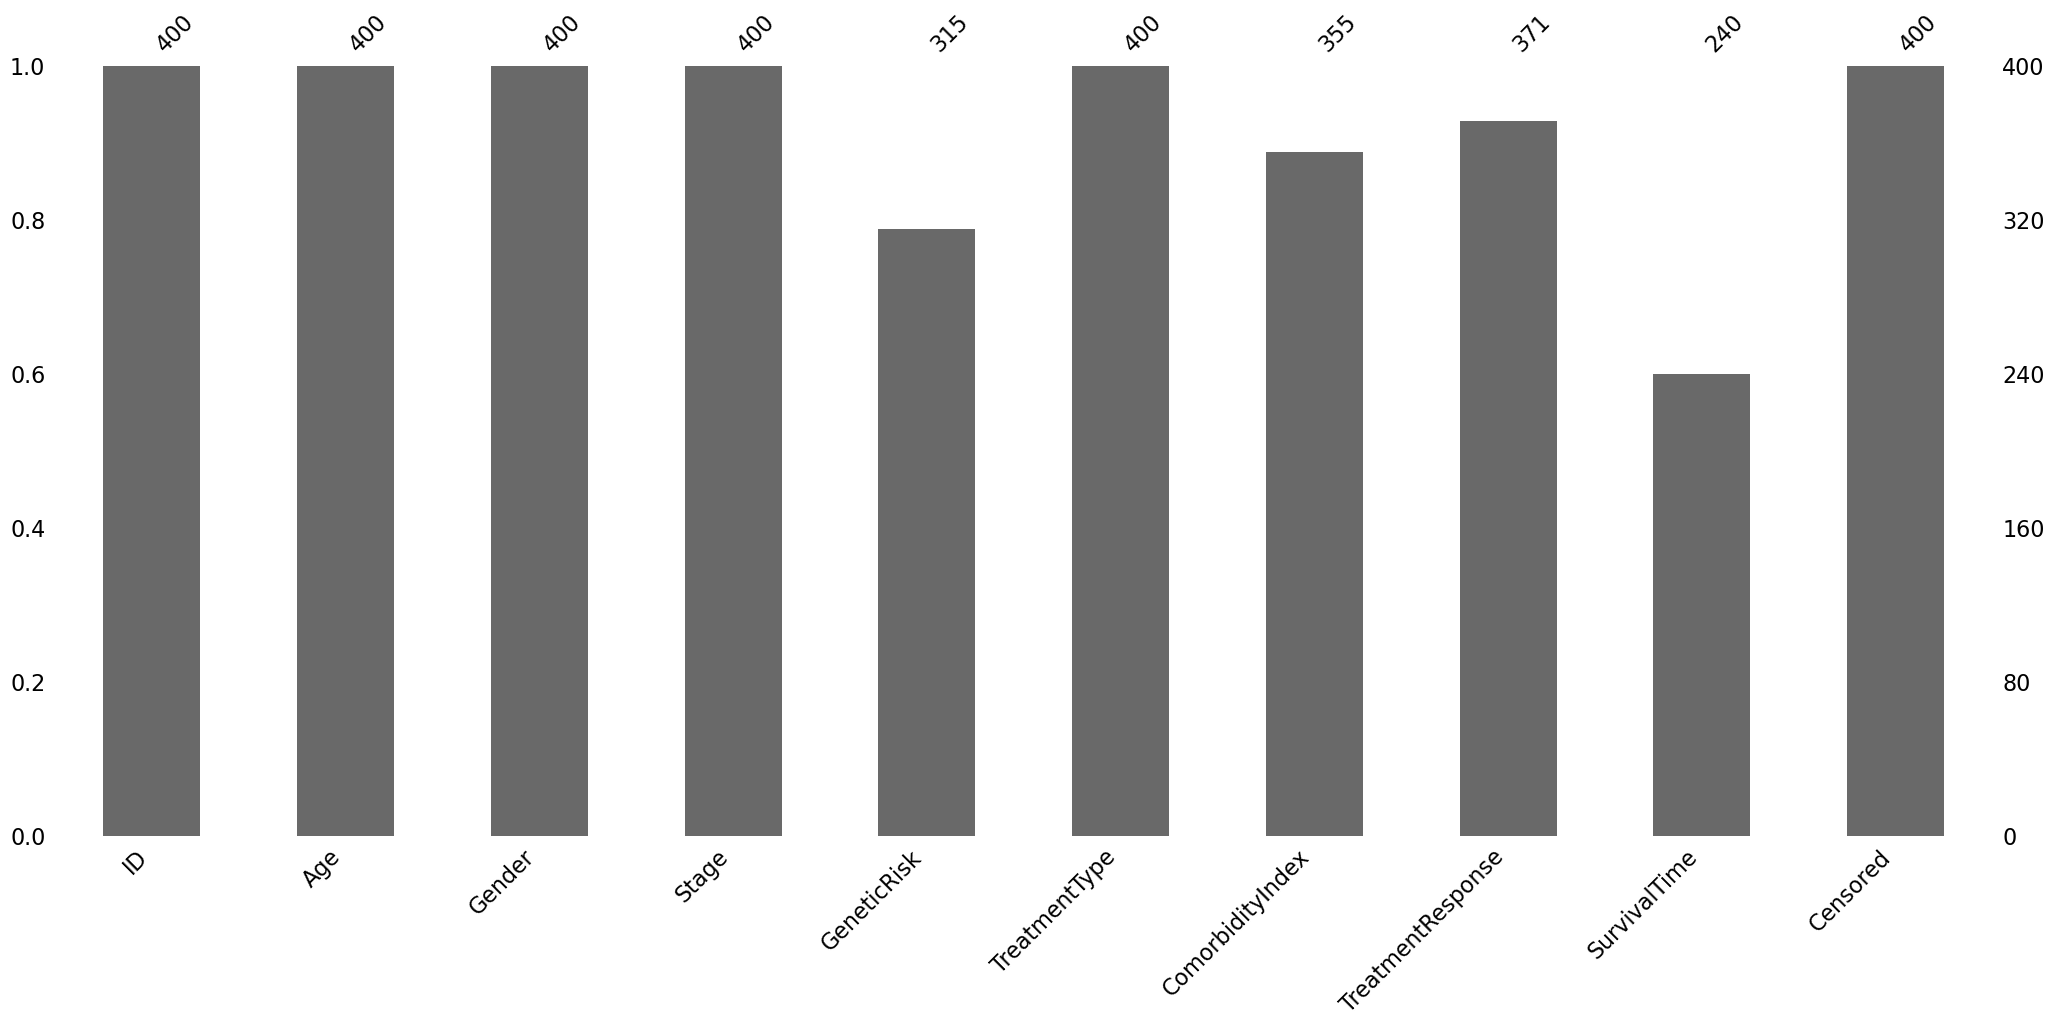

In [7]:
msno.bar(startingDF)

By the first analysis of this plot, we can conclude that:
- "Genetic Risk" has 85 missing values (400-315).
- "Comorbity Index" has 45 missing values (400-355)
- "Treatment Response" has 29 missing values (400 - 371)
- "Survavil Time" has 160 missing values (400 - 240)

Plot of the heat map

<Axes: >

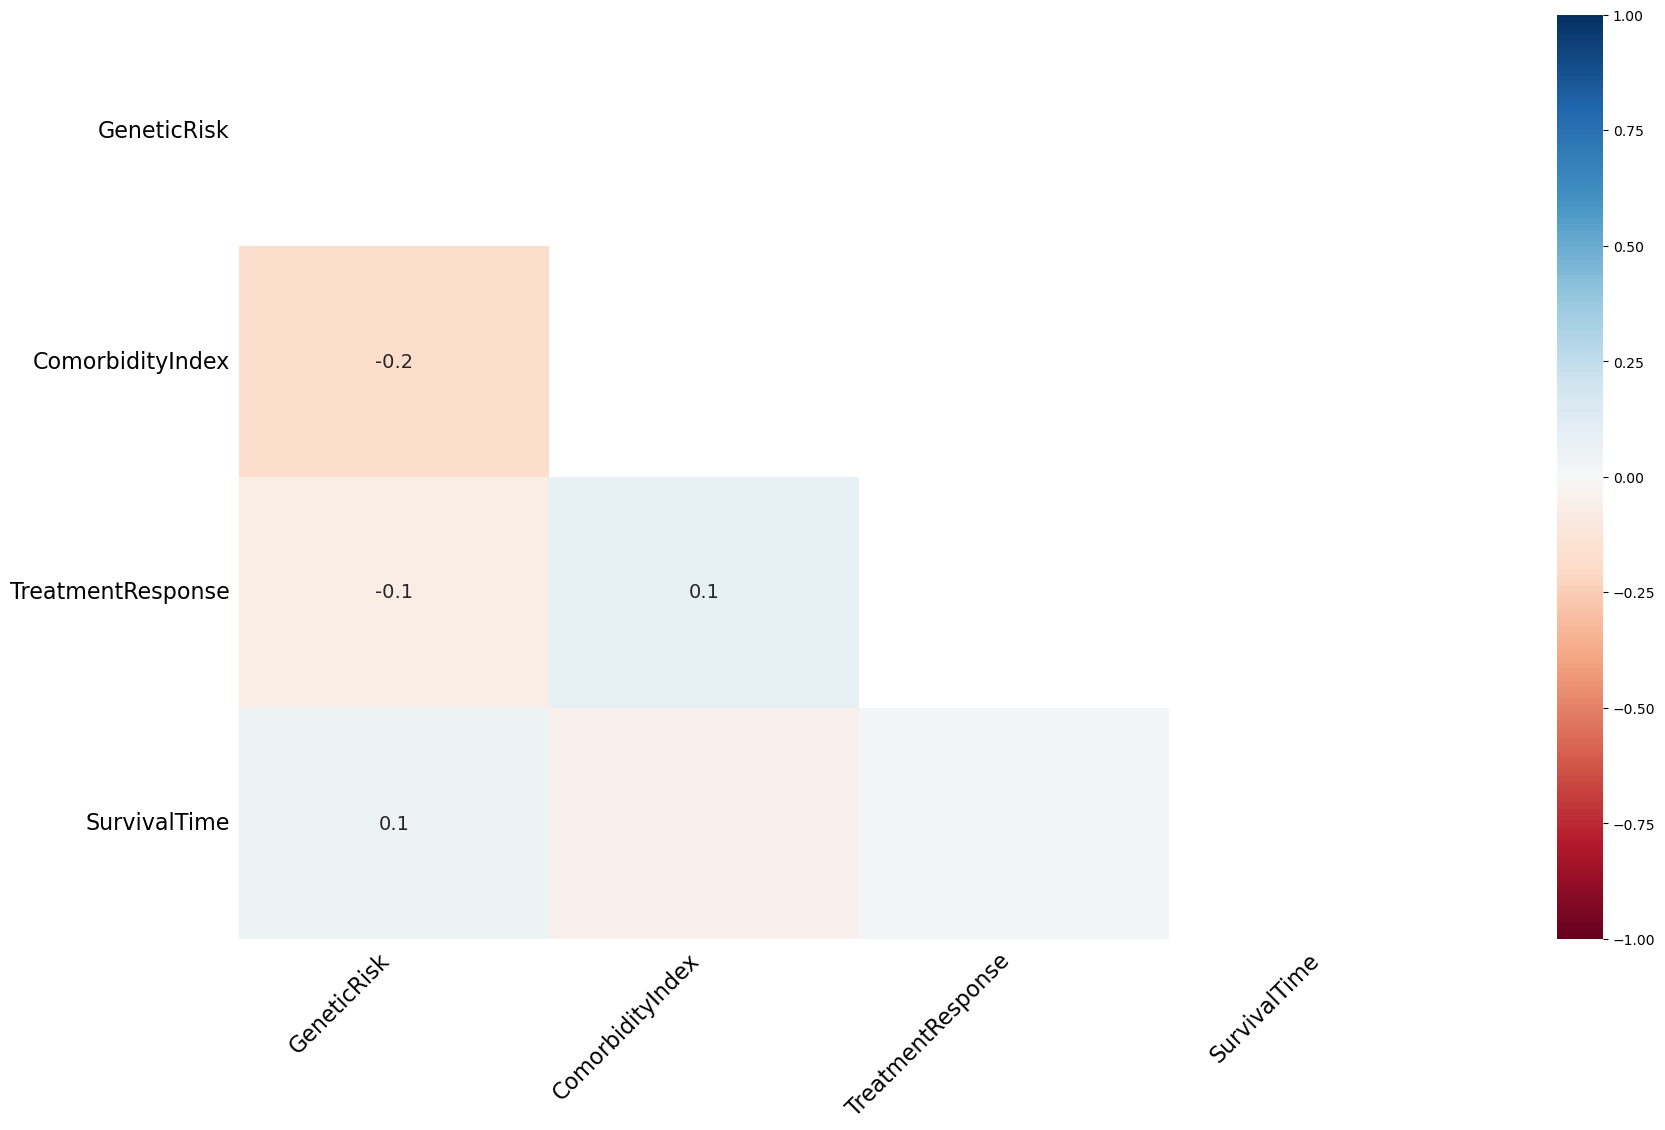

In [8]:
msno.heatmap(startingDF)

<Axes: >

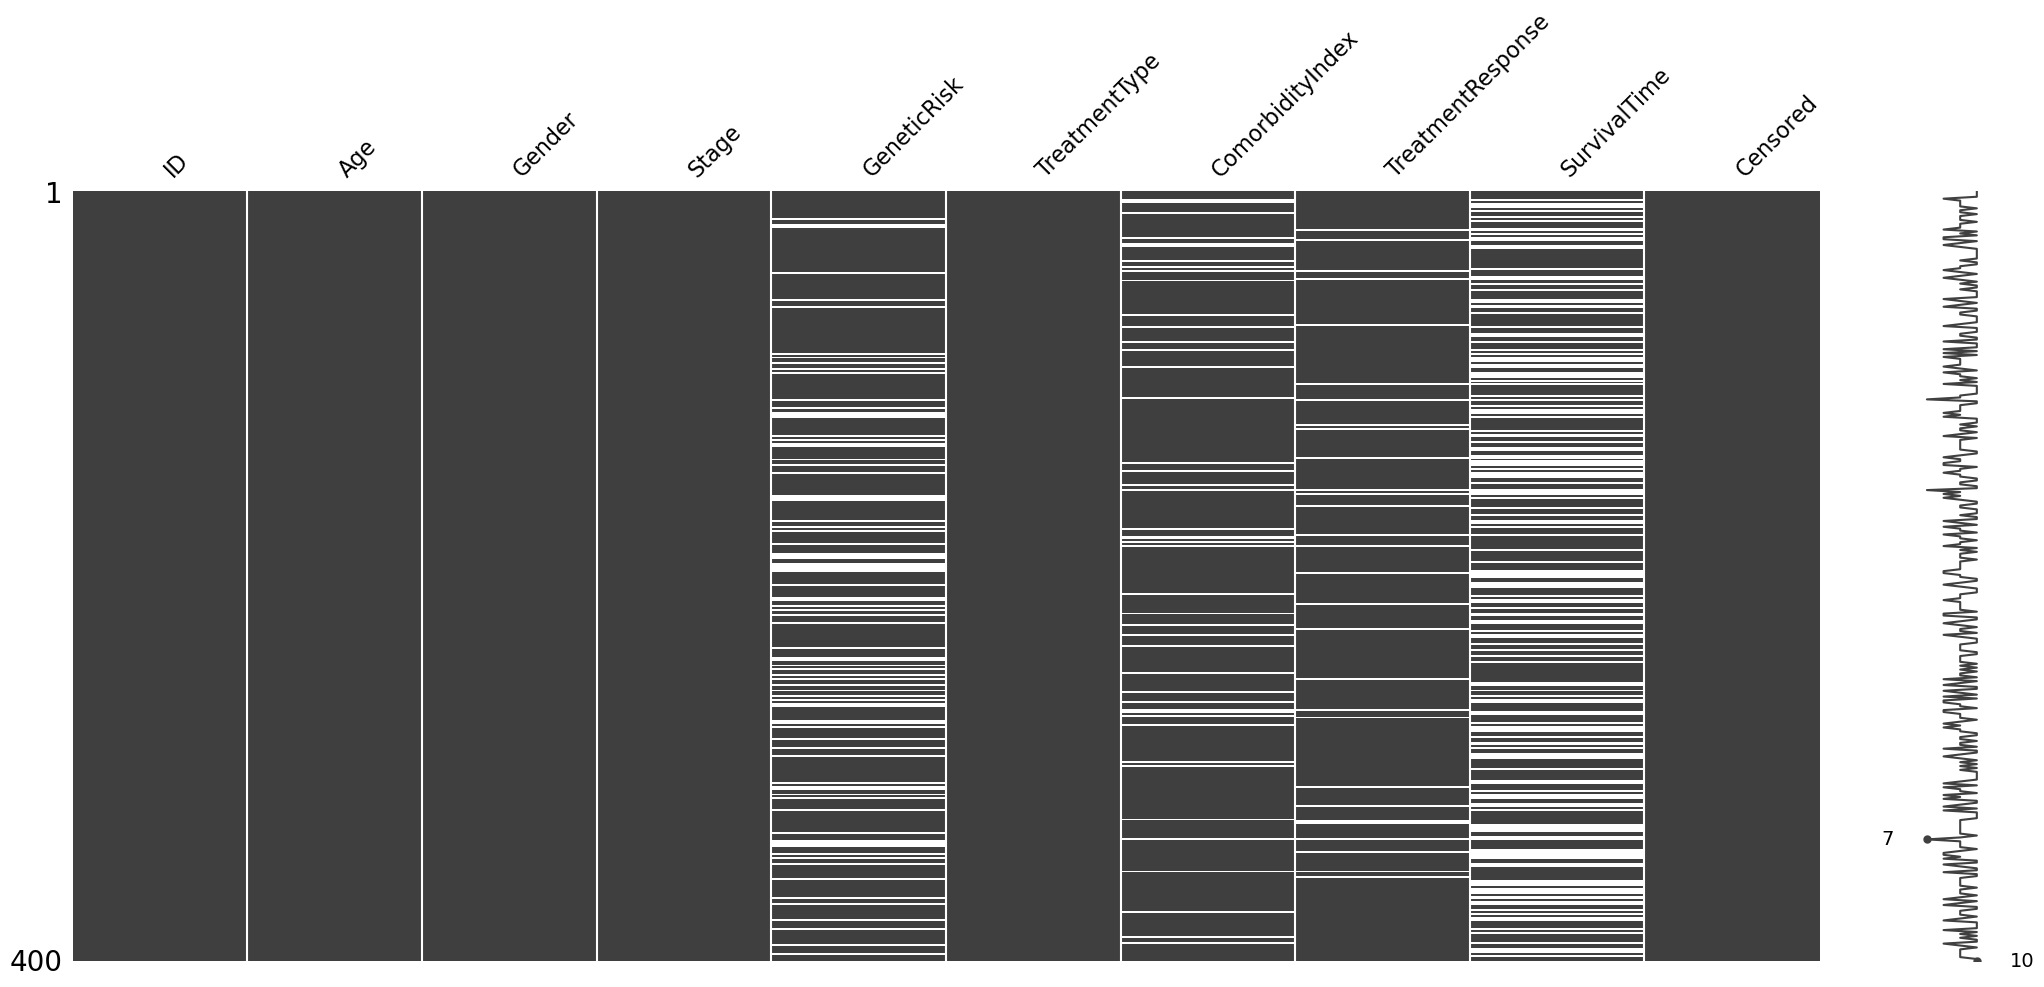

In [9]:
msno.matrix(startingDF)

#### Investigating the "Censored" entries

Number of censored patients:  79
Number of not censored patients:  321


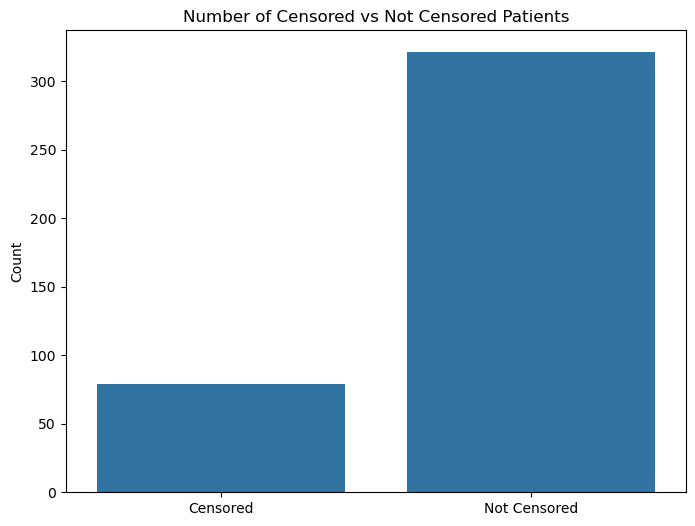

In [10]:
numCensored = startingDF[startingDF["Censored"] == 1].shape[0]
numNotCensored = startingDF[startingDF["Censored"] == 0].shape[0]
print("Number of censored patients: ", numCensored)
print("Number of not censored patients: ", numNotCensored)

plt.figure(figsize=(8, 6))
sns.barplot(x=['Censored', 'Not Censored'], y=[numCensored, numNotCensored])
plt.title('Number of Censored vs Not Censored Patients')
plt.ylabel('Count')
plt.show()

We start by investigating the NaN entries

In [11]:
DFofCensored = startingDF[startingDF["Censored"] == 1]
DFofCensored = DFofCensored.drop(columns=["Censored"])
DFofCensored[DFofCensored.isnull().any(axis=1)].head(20)

,ID,Age,Gender,Stage,GeneticRisk,TreatmentType,ComorbidityIndex,TreatmentResponse,SurvivalTime
14,14,77.0,0,3,NaN,1,2.0,0.0,3.3
27,27,47.0,1,2,1.0,0,NaN,1.0,5.3
42,42,73.0,1,4,NaN,1,2.0,0.0,3.3
46,46,52.0,0,2,0.0,0,NaN,0.0,1.9
69,69,66.0,1,1,0.0,0,0.0,NaN,4.0
107,107,58.0,0,3,0.0,0,NaN,0.0,3.8
158,158,72.0,1,3,NaN,1,1.0,0.0,2.1
160,160,81.0,1,4,NaN,1,3.0,0.0,2.1
175,175,55.0,1,3,0.0,0,NaN,0.0,3.9
176,176,87.0,0,1,NaN,1,1.0,1.0,8.3


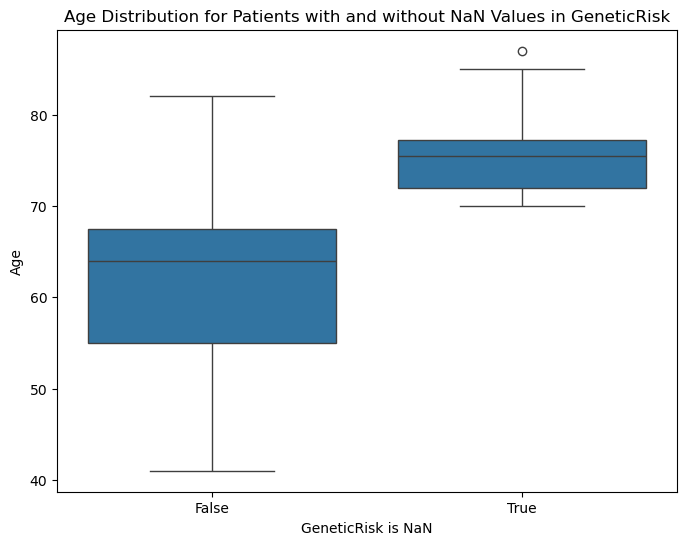

In [12]:
DFofCensored[DFofCensored["GeneticRisk"].isnull()] #Age is very similar in the case of NaN values of GeneticRisk
                                                   #What about the other way around?
                                                   
plt.figure(figsize=(8, 6))
sns.boxplot(x=DFofCensored["GeneticRisk"].isnull(), y=DFofCensored["Age"])
plt.title("Age Distribution for Patients with and without NaN Values in GeneticRisk")
plt.xlabel("GeneticRisk is NaN")
plt.ylabel("Age")
plt.show()

In [13]:
DFofCensored[DFofCensored["GeneticRisk"].isnull()].describe() # Maximum age to make the GeneticRisk test is below 70 

,ID,Age,Gender,Stage,GeneticRisk,TreatmentType,ComorbidityIndex,TreatmentResponse,SurvivalTime
count,20.000000,20.000000,20.000000,20.000000,0.0,20.000000,20.000000,19.000000,20.000000
mean,228.550000,75.800000,0.600000,2.950000,NaN,0.600000,1.250000,0.473684,4.265000
std,94.438772,4.652108,0.502625,1.050063,NaN,0.502625,0.850696,0.512989,2.216511
min,14.000000,70.000000,0.000000,1.000000,NaN,0.000000,0.000000,0.000000,1.500000
25%,181.250000,72.000000,0.000000,2.750000,NaN,0.000000,1.000000,0.000000,2.725000
50%,239.500000,75.500000,1.000000,3.000000,NaN,1.000000,1.000000,0.000000,3.400000
75%,315.000000,77.250000,1.000000,4.000000,NaN,1.000000,2.000000,1.000000,5.050000
max,357.000000,87.000000,1.000000,4.000000,NaN,1.000000,3.000000,1.000000,8.500000


In [14]:
DFofCensored[DFofCensored["GeneticRisk"].notnull()].describe() # Maximum age to make the GeneticRisk test is below 70

,ID,Age,Gender,Stage,GeneticRisk,TreatmentType,ComorbidityIndex,TreatmentResponse,SurvivalTime
count,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,47.000000,55.000000,59.000000
mean,189.491525,61.847458,0.610169,2.559322,0.237288,0.508475,1.042553,0.581818,4.472881
std,116.728003,8.384743,0.491898,0.969735,0.429072,0.504219,0.883605,0.497807,1.607829
min,1.000000,41.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.400000
25%,78.500000,55.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,3.650000
50%,209.000000,64.000000,1.000000,2.000000,0.000000,1.000000,1.000000,1.000000,4.100000
75%,281.500000,67.500000,1.000000,3.000000,0.000000,1.000000,2.000000,1.000000,5.400000
max,388.000000,82.000000,1.000000,4.000000,1.000000,1.000000,3.000000,1.000000,9.500000


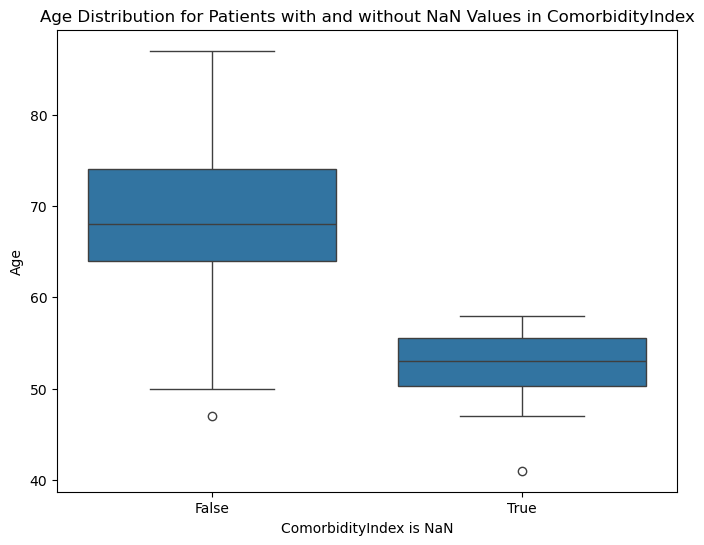

In [15]:
DFofCensored[DFofCensored["ComorbidityIndex"].isnull()]
plt.figure(figsize=(8, 6))
sns.boxplot(x=DFofCensored["ComorbidityIndex"].isnull(), y=DFofCensored["Age"])
plt.title("Age Distribution for Patients with and without NaN Values in ComorbidityIndex")
plt.xlabel("ComorbidityIndex is NaN")
plt.ylabel("Age")
plt.show()

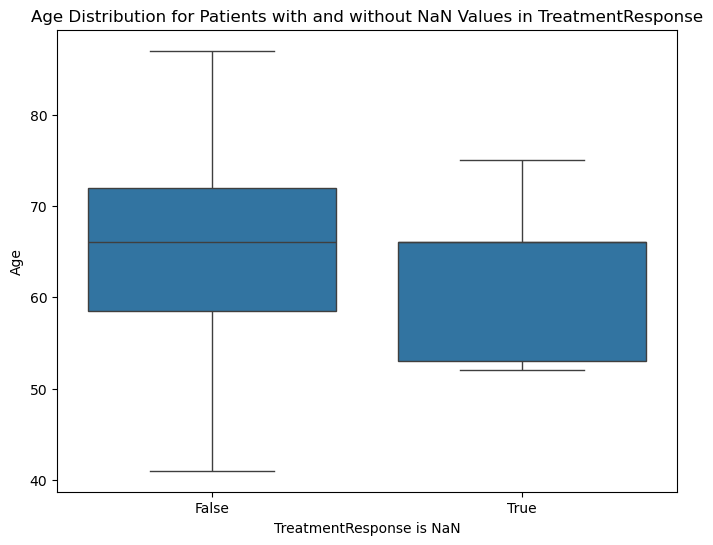

In [16]:
DFofCensored[DFofCensored["TreatmentResponse"].isnull()]
plt.figure(figsize=(8, 6))
sns.boxplot(x=DFofCensored["TreatmentResponse"].isnull(), y=DFofCensored["Age"])
plt.title("Age Distribution for Patients with and without NaN Values in TreatmentResponse")
plt.xlabel("TreatmentResponse is NaN")
plt.ylabel("Age")
plt.show()

#### Point 1: If one drops all the data points with missing values, plus the censored ones, would it be possible to fit a model?

In [17]:
#Drop NaN values
DFnoNA = startingDF.dropna()
#Confirm that there are no NaN values
DFnoNA.isnull().any()

ID                   False
Age                  False
Gender               False
Stage                False
GeneticRisk          False
TreatmentType        False
ComorbidityIndex     False
TreatmentResponse    False
SurvivalTime         False
Censored             False
dtype: bool

Initial number of rows:  400
Number of current rows:  153
Number of rows dropped:  247


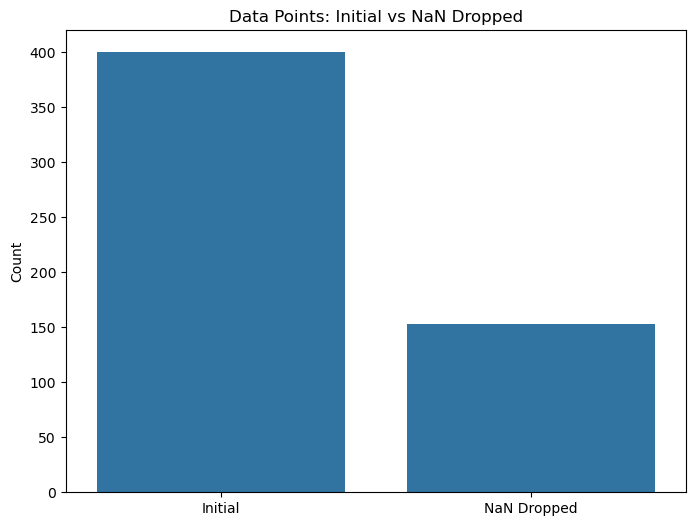

In [18]:
print("Initial number of rows: ", startingDF.shape[0])
print("Number of current rows: ", DFnoNA.shape[0])
print("Number of rows dropped: ", startingDF.shape[0] - DFnoNA.shape[0])
plt.figure(figsize=(8, 6))
sns.barplot(x=['Initial', 'NaN Dropped'], y=[startingDF.shape[0], DFnoNA.shape[0]])
plt.title('Data Points: Initial vs NaN Dropped')
plt.ylabel('Count')
plt.show()

In [19]:
#Drop censored data - We should change the name to a different one to avoid different datasets with same name
DFnoNACensored = DFnoNA[DFnoNA["Censored"] != 1]
#Confirm that there are no censored values
DFnoNACensored["Censored"].unique()

array([0], dtype=int64)

Initial number of rows:  400
Number of current rows (after droping NaN and censored entries):  109
Number of rows dropped:  291


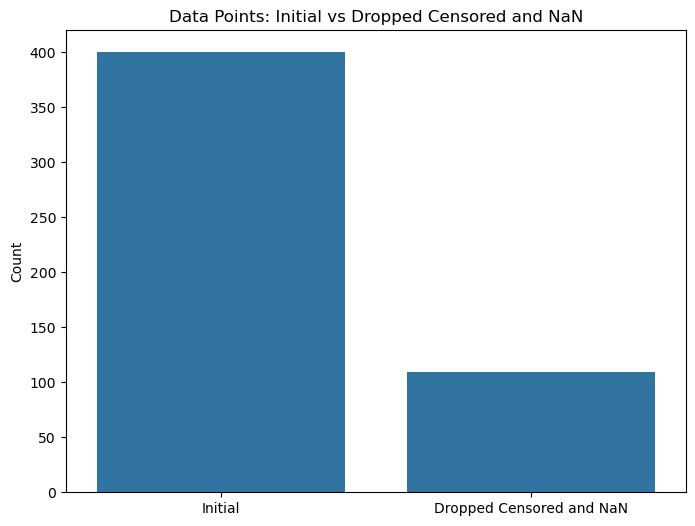

In [20]:
#Print the number of starting rows and the number of rows after dropping censored data
print("Initial number of rows: ", startingDF.shape[0])
print("Number of current rows (after droping NaN and censored entries): ", DFnoNACensored.shape[0])
print("Number of rows dropped: ", startingDF.shape[0] - DFnoNACensored.shape[0])
plt.figure(figsize=(8, 6))
sns.barplot(x=['Initial', 'Dropped Censored and NaN'], y=[startingDF.shape[0], DFnoNACensored.shape[0]])
plt.title('Data Points: Initial vs Dropped Censored and NaN')
plt.ylabel('Count')
plt.show()

Number of patients in training set:  88
Number of patients in test set:  11
Number of patients in validation set:  10


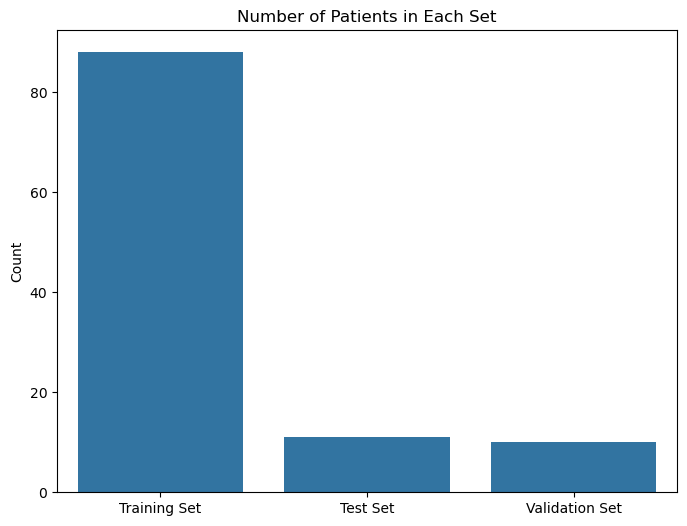

In [21]:
X = DFnoNACensored[X_cols_universal]
y = DFnoNACensored[y_cols_universal]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

print("Number of patients in training set: ", X_train.shape[0])
print("Number of patients in test set: ", X_test.shape[0])
print("Number of patients in validation set: ", X_val.shape[0])

plt.figure(figsize=(8, 6))
sns.barplot(x=['Training Set', 'Test Set', 'Validation Set'], y=[X_train.shape[0], X_test.shape[0], X_val.shape[0]])
plt.title('Number of Patients in Each Set')
plt.ylabel('Count')
plt.show()

After cleaning the dataset, we end up with only 109 patients. While it’s technically possible to proceed with an 80/10/10 split and use data from 88 patients for training, this might not be the most effective approach. Given the limited number of patients provided (400), we can and, most likely, should explore methods to "fill" these gaps instead of dropping patients with missing information. This way, we can maximize the available data and retain more patients for modeling.

All in all, although continuing with this subset is possible, a different approach that preserves more data would likely yield better insights.

#### Point 2: Drop the columns containing the features with missing data and the censored data points, or missing survival time. How many points are there left?

In [22]:
missing_columns = startingDF.columns[startingDF.isnull().any()]
missing_columns = missing_columns[missing_columns != 'SurvivalTime'] #We shouldn't remove the label column
print(f"Columns with missing data (excluding 'SurvivalTime'): {missing_columns.tolist()}")

Columns with missing data (excluding 'SurvivalTime'): ['GeneticRisk', 'ComorbidityIndex', 'TreatmentResponse']


In [23]:
startingDF_cleaned = startingDF.drop(columns=missing_columns)
startingDF_cleaned = startingDF_cleaned[(startingDF_cleaned['Censored'] == 0) & (startingDF_cleaned['SurvivalTime'].notna())]
startingDF_cleaned = startingDF_cleaned.drop(columns=['Censored'])

In [24]:
#Print the remaining columns
print(startingDF_cleaned.columns.tolist()) # Remaining columns after dropping columns with missing data and censored data

['ID', 'Age', 'Gender', 'Stage', 'TreatmentType', 'SurvivalTime']


Initial number of data points: 400
Remaining data points: 161


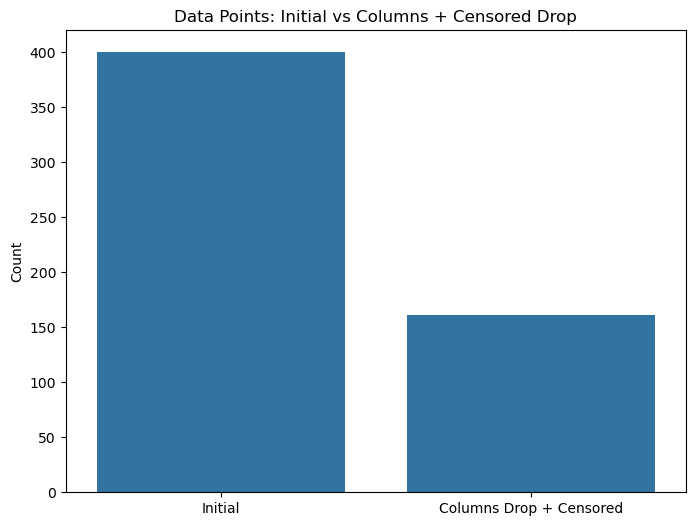

In [25]:
remaining_points = startingDF_cleaned.shape[0]
print(f"Initial number of data points: {startingDF.shape[0]}")
print(f"Remaining data points: {remaining_points}")
plt.figure(figsize=(8, 6))
sns.barplot(x=['Initial', 'Columns Drop + Censored'], y=[startingDF.shape[0], remaining_points])
plt.title('Data Points: Initial vs Columns + Censored Drop')
plt.ylabel('Count')
plt.show()

After removing the features with missing values — namely "GeneticRisk", "ComorbidityIndex", and "TreatmentResponse"— we were left with the following columns: "ID", "Age", "Gender", "Stage", "TreatmentType", and "SurvivalTime". It is worth noting that the "ID" column has little predictive value and can arguably be dropped.    
Following the removal of entries with missing or censored data, the dataset, originally consisting of 400 rows, was reduced to 161 rows, resulting in a loss of nearly almost 60% (59.75%) of the data.

Number of patients in training set:  88
Number of patients in test set:  11
Number of patients in validation set:  10


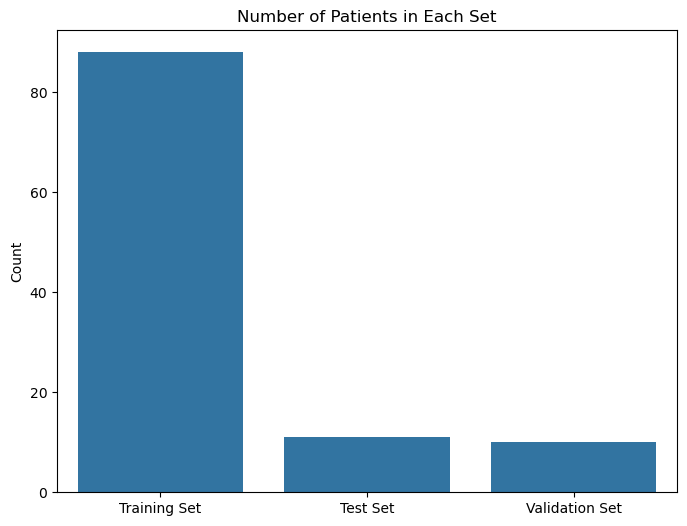

In [26]:
X_1 = startingDF_cleaned[["Age", "Gender", "Stage", "TreatmentType"]]
y_1 = startingDF_cleaned[["Age", "Gender", "Stage", "TreatmentType"]]

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.1)
X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(X_train_1, y_train_1, test_size=0.1)

print("Number of patients in training set: ", X_train.shape[0])
print("Number of patients in test set: ", X_test.shape[0])
print("Number of patients in validation set: ", X_val.shape[0])

plt.figure(figsize=(8, 6))
sns.barplot(x=['Training Set', 'Test Set', 'Validation Set'], y=[X_train.shape[0], X_test.shape[0], X_val.shape[0]])
plt.title('Number of Patients in Each Set')
plt.ylabel('Count')
plt.show()

It's worth mention that, on one hand, removing the features with NaN values in addition to Censored data points allows us to retain more data points and, therefore, more information overall. However, a potential drawback is that this approach removes crucial information that is likely valuable for the models we aim to create.

In [27]:
print(f"Initial number of data points: {startingDF.shape[0]}")
print(f"Remaining data points after dropping columns: {remaining_points}")
print("Remaining data points after droping NaN and censored entries: ", DFnoNA.shape[0])

Initial number of data points: 400
Remaining data points after dropping columns: 161
Remaining data points after droping NaN and censored entries:  153


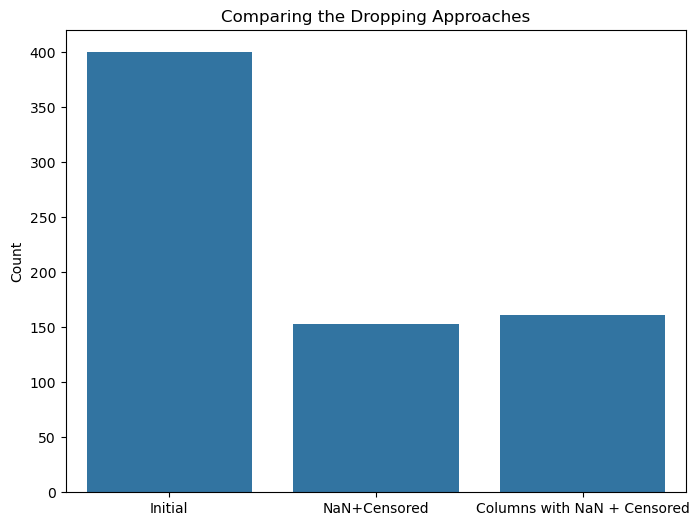

In [28]:
plt.figure(figsize=(8, 6))
sns.barplot(x=['Initial', 'NaN+Censored', 'Columns with NaN + Censored'], y=[startingDF.shape[0], DFnoNA.shape[0], remaining_points])
plt.title('Comparing the Dropping Approaches')
plt.ylabel('Count')
plt.show()

#### Point 3: Check the pairplot between the remaining features and the target variable. Analyze and comment in the slides.

In [29]:
# Identify columns without missing data
remaining_columns = startingDF_cleaned.columns
remaining_columns = remaining_columns.drop('ID') #We don't want to use the ID column as a feature
remaining_columns

Index(['Age', 'Gender', 'Stage', 'TreatmentType', 'SurvivalTime'], dtype='object')

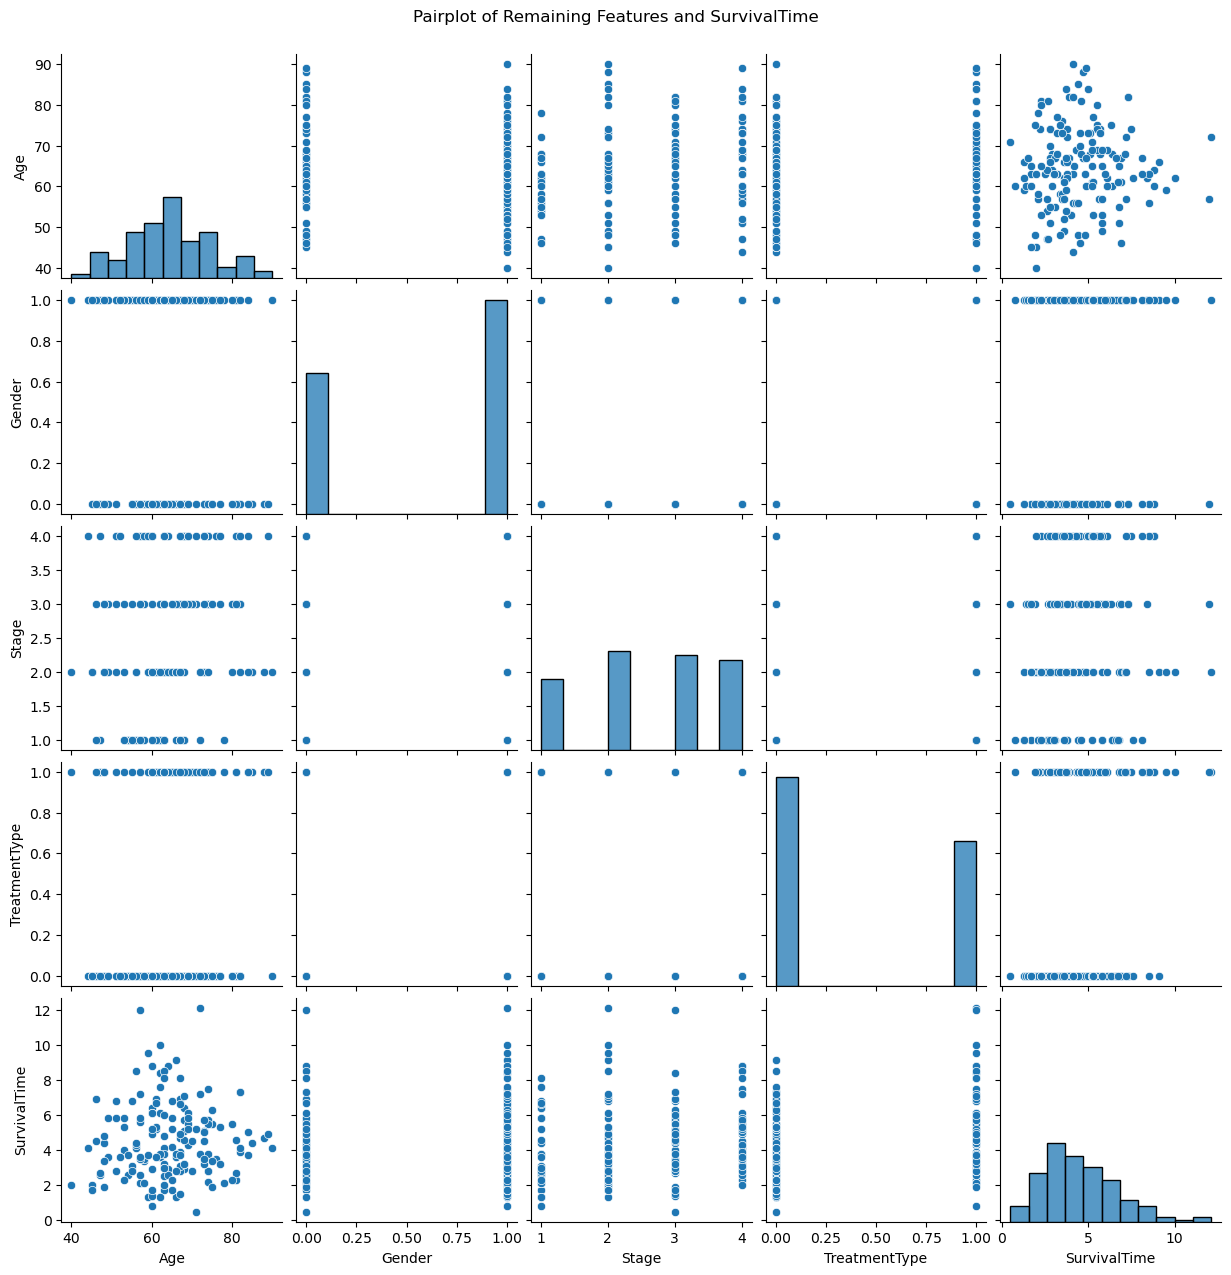

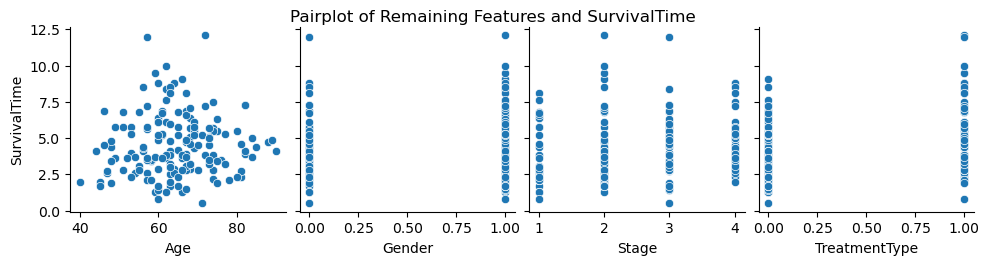

In [30]:
pairplot_data = startingDF_cleaned[remaining_columns]
sns.pairplot(pairplot_data)
plt.suptitle("Pairplot of Remaining Features and SurvivalTime", y=1.02)
plt.show()

sns.pairplot(pairplot_data, x_vars=['Age', 'Gender', 'Stage', 'TreatmentType'], y_vars='SurvivalTime')
plt.suptitle("Pairplot of Remaining Features and SurvivalTime", y=1.02)
plt.show()

<Axes: >

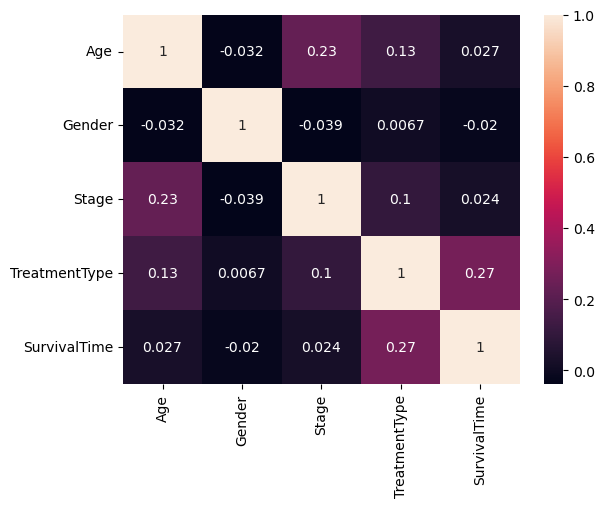

In [31]:
corr = startingDF[remaining_columns].corr()
sns.heatmap(corr,annot=True)

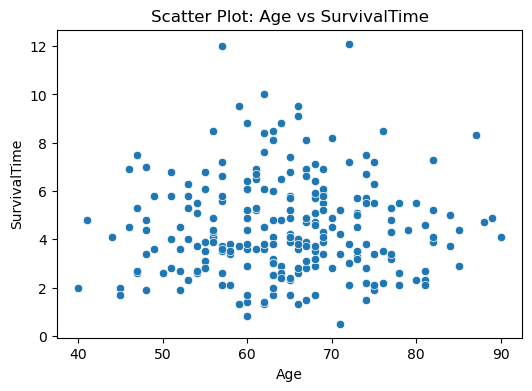

Correlation between Age and Surviva lTime: 0.03


In [32]:
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Age', y='SurvivalTime', data=startingDF)
plt.title("Scatter Plot: Age vs SurvivalTime")
plt.show()

correlation_age_survival = startingDF[['Age', 'SurvivalTime']].corr().iloc[0, 1]
print(f"Correlation between Age and Surviva lTime: {correlation_age_survival:.2f}")


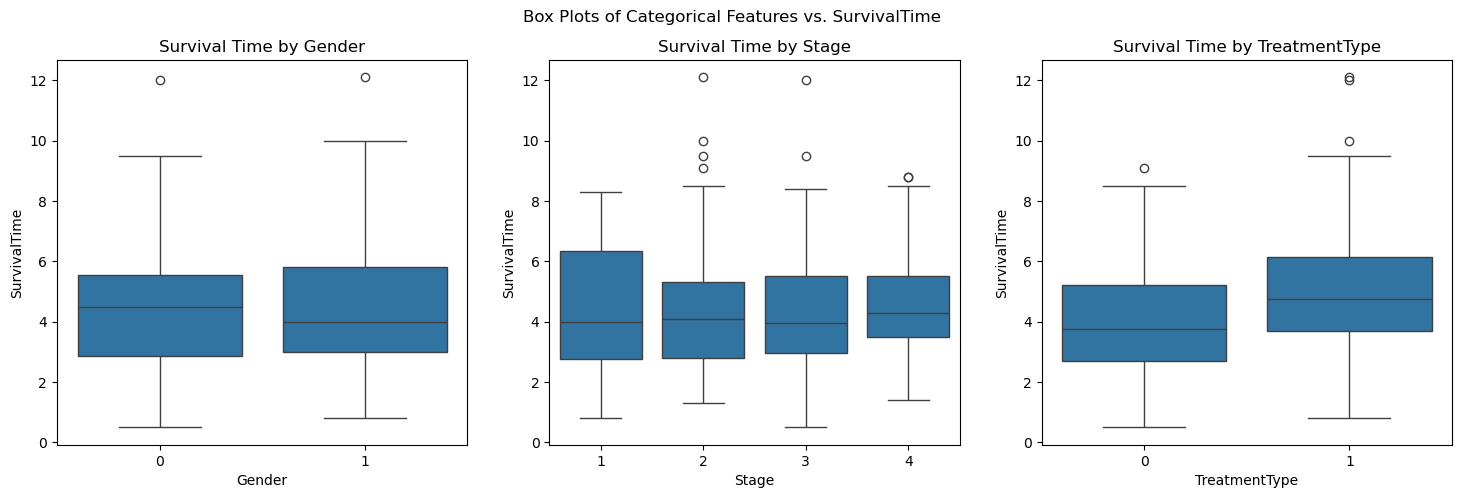

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(x='Gender', y='SurvivalTime', data=startingDF, ax=axes[0])
axes[0].set_title("Survival Time by Gender")

sns.boxplot(x='Stage', y='SurvivalTime', data=startingDF, ax=axes[1])
axes[1].set_title("Survival Time by Stage")

sns.boxplot(x='TreatmentType', y='SurvivalTime', data=startingDF, ax=axes[2])
axes[2].set_title("Survival Time by TreatmentType")

plt.suptitle("Box Plots of Categorical Features vs. SurvivalTime")
plt.show()

#### Point 4: Define the matrix X with the features as columns and examples as rows, and y as a vector with the Survival Time.

In [34]:
Remaining_X = startingDF_cleaned.drop(columns=['SurvivalTime', 'ID'])
Remaining_y = startingDF_cleaned['SurvivalTime']

In [35]:
Remaining_X

,Age,Gender,Stage,TreatmentType
0,65.0,0,2,0
3,81.0,1,4,1
5,47.0,1,4,1
9,68.0,1,1,0
11,56.0,0,2,0
...,...,...,...,...
391,80.0,0,2,0
392,52.0,1,4,0
396,72.0,1,2,0
398,63.0,0,4,1


In [36]:
Remaining_y

0      4.2
3      2.3
5      2.6
9      6.4
11     4.1
      ... 
391    2.3
392    3.6
396    7.2
398    8.1
399    3.7
Name: SurvivalTime, Length: 161, dtype: float64

In [37]:
X = DFnoNA[X_cols_universal]
y = DFnoNA[y_cols_universal]

In [38]:
X

,Age,Gender,Stage,GeneticRisk,TreatmentType,ComorbidityIndex,TreatmentResponse
0,65.0,0,2,1.0,0,0.0,0.0
1,68.0,1,2,0.0,1,1.0,1.0
2,68.0,1,3,1.0,1,0.0,1.0
3,81.0,1,4,1.0,1,3.0,0.0
9,68.0,1,1,0.0,0,1.0,1.0
...,...,...,...,...,...,...,...
388,54.0,0,4,0.0,1,1.0,1.0
389,53.0,1,2,0.0,0,0.0,1.0
392,52.0,1,4,1.0,0,0.0,0.0
398,63.0,0,4,0.0,1,2.0,1.0


In [39]:
y

,SurvivalTime,Censored
0,4.2,0
1,4.7,1
2,3.5,1
3,2.3,0
9,6.4,0
...,...,...
388,5.5,1
389,5.3,0
392,3.6,0
398,8.1,0


#### Point 5: Consider a train, validation and test split, against a train, test split, with cross validation. What validation procedure is more data-efficient? Justify your answer with evidence from the dataset.

With a dataset of only 161 rows, it’s very important to use a validation procedure that maximizes data utilization. We will compare two approaches: Train, Validation and Test split without Cross-Validation and Train-Test split with Cross-Validation.   

- Train, Validation, and Test Split: In a typical train-validation-test split, for example 80-10-10, we would split approximately 129 rows for training, 16 rows for validation, and 16 rows for testing.
The limitations can appear in the form of insufficient data in order to train a "decent" model. The small validation, in our case a validation set of 16 rows, may not provide reliable estimates for tuning hyperparameters (such as the degree in a polynomial regression, the alpha in a Ridge regression or the K in a KNN regression), as a small sample size can lead to high variance in validation performance.   
In terms of data efficiency, this type of split is not very efficient for smaller datasets, as cutting aside separate validation and test sets reduces the number of samples available for training.

- Train-Test Split with Cross-Validation:
In this approach, we split the data into 80% for training (about 129 rows) and 20% for testing (about 32 rows).
An example of Cross-Validation is k-fold [[3]](#footnote3).   
Cross-validation is more data-efficient because it allows the model to be trained and validated on different subsets of the training data without needing a separate validation set. It also provides a more reliable estimate of model performance by averaging results across folds, leading to better hyperparameter tuning and model selection. Not only that but this approach is highly data-efficient for smaller datasets like ours, as it maximizes the use of the available data for both training and validation while keeping a separate test set for unbiased evaluation.

In [40]:
startingDF_yCleaned = startingDF.dropna(subset=["SurvivalTime"])
X_universal = startingDF_yCleaned[X_cols_universal]
y_universal = startingDF_yCleaned[y_cols_universal]
survival_times = y_universal["SurvivalTime"]

df_survival_nan = startingDF[startingDF["SurvivalTime"].isna()]
X_universal_nan = df_survival_nan[X_cols_universal]
y_universal_nan = df_survival_nan[y_cols_universal]

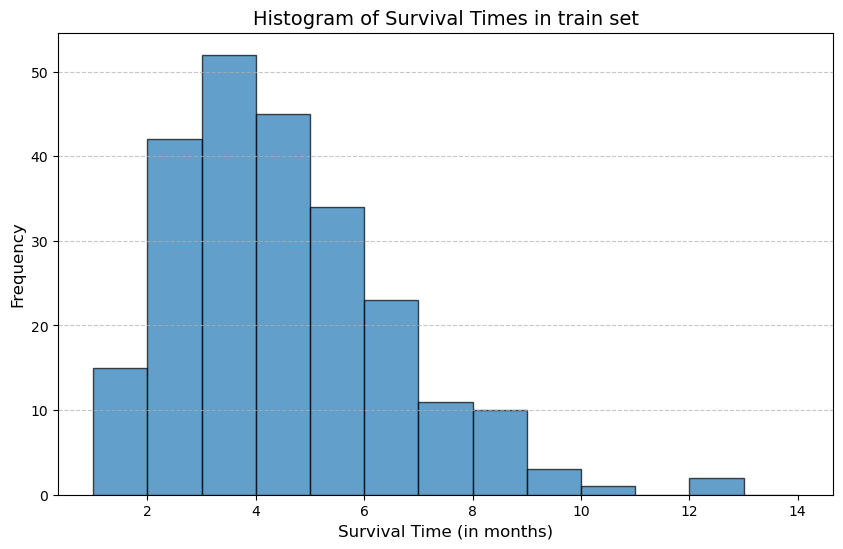

In [41]:
plt.figure(figsize=(10, 6))
plt.hist(survival_times, bins=np.arange(1, max(survival_times) + 2), edgecolor='black', alpha=0.7)
plt.title('Histogram of Survival Times in train set', fontsize=14)
plt.xlabel('Survival Time (in months)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### Standard data splitting 

The mean survival time in the training set is 4.39 months
The mean survival time in the test set is 5.28 months


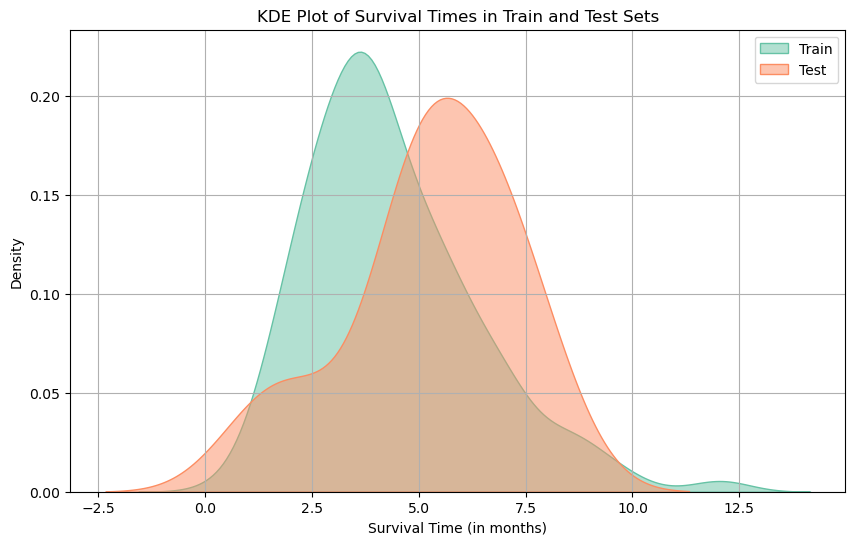

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_universal, y_universal, test_size=0.1, random_state=38)

survival_train = y_train["SurvivalTime"]
survival_test = y_test["SurvivalTime"]

print(f"The mean survival time in the training set is {survival_train.mean():.2f} months")
print(f"The mean survival time in the test set is {survival_test.mean():.2f} months")

palette = sns.color_palette("Set2")
plt.figure(figsize=(10, 6))
sns.kdeplot(survival_train, label="Train", fill=True, alpha=0.5, color=palette[0])
sns.kdeplot(survival_test, label="Test", fill=True, alpha=0.5, color=palette[1])
plt.legend()
plt.title("KDE Plot of Survival Times in Train and Test Sets")
plt.xlabel("Survival Time (in months)")
plt.ylabel("Density")
plt.grid(True)
plt.show()

#### Global Datasets for Train/Test Validation using Stratified split

In [43]:
print("Shape of X_universal:", X_universal.shape)
print("Shape of y_universal:", y_universal.shape)

Shape of X_universal: (240, 7)
Shape of y_universal: (240, 2)


In [122]:
random_state = None

best_models = {}
#bin = np.quantile(survival_times, [0,0.25, 0.5, 0.75, 1])
#y_binned = pd.cut(survival_times.values.flatten(), bins=bin, labels=False, include_lowest=True)
#X_train, X_test, y_train, y_test = train_test_split(X_universal, y_universal, test_size=0.1, stratify=y_binned, random_state=random_state)



c0 = startingDF_yCleaned[startingDF_yCleaned["Censored"] == 0]
c1 = startingDF_yCleaned[startingDF_yCleaned["Censored"] == 1]
bins = [0, 2, 5, 6, 7, 11, 14]

y_binned_c0 = pd.cut(c0["SurvivalTime"].values.flatten(), bins=bins, labels=False, include_lowest=True)
y_binned_c1 = pd.cut(c1["SurvivalTime"].values.flatten(), bins=bins, labels=False, include_lowest=True)


X_train_c0, X_test_c0, y_train_c0, y_test_c0 = train_test_split(c0[X_cols_universal], c0[y_cols_universal], test_size=0.1, stratify=y_binned_c0, random_state=random_state)
X_train_c1, X_test_c1, y_train_c1, y_test_c1 = train_test_split(c1[X_cols_universal], c1[y_cols_universal], test_size=0.1, stratify=y_binned_c1, random_state=random_state)


X_train = pd.concat([X_train_c0, X_train_c1])
y_train = pd.concat([y_train_c0, y_train_c1])
X_test = pd.concat([X_test_c0, X_test_c1])
y_test = pd.concat([y_test_c0, y_test_c1])

X_train_NaN, X_test_NaN, y_train_NaN, y_test_NaN = train_test_split(X_universal_nan, y_universal_nan, test_size=0.1, random_state=random_state)

In [123]:
mean_censored_train = y_train['Censored'].mean()
mean_censored_test = y_test['Censored'].mean()

print(f"The mean of the SurvivalTime in the training set is {y_train['SurvivalTime'].mean():.2f}")
print(f"The mean of the SurvivalTime in the test set is {y_test['SurvivalTime'].mean():.2f}")

print(f"The mean of the censored values in the training set is {mean_censored_train:.2f}")
print(f"The mean of the censored values in the test set is {mean_censored_test:.2f}")

The mean of the SurvivalTime in the training set is 4.49
The mean of the SurvivalTime in the test set is 4.38
The mean of the censored values in the training set is 0.33
The mean of the censored values in the test set is 0.32


#### Analyzing the Stratified Split

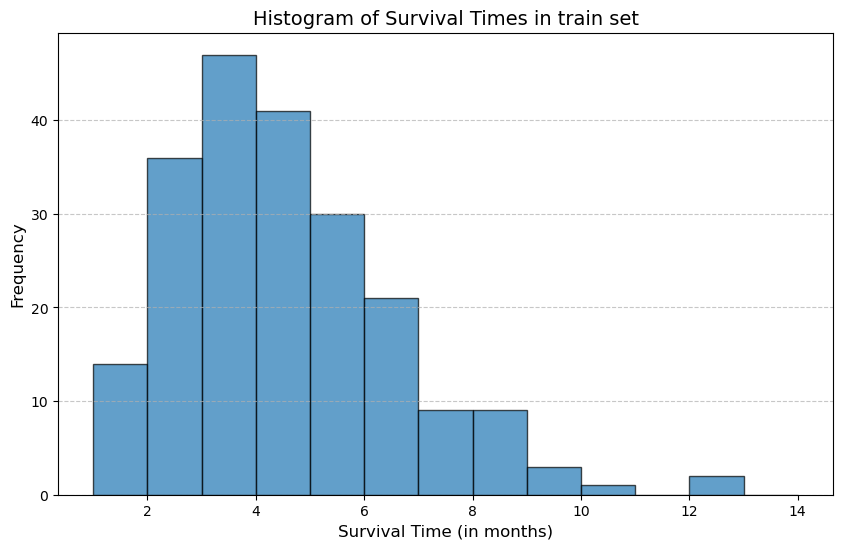

In [124]:
survival_times = y_train["SurvivalTime"]
plt.figure(figsize=(10, 6))
plt.hist(survival_times, bins=np.arange(1, max(survival_times) + 2), edgecolor='black', alpha=0.7)
plt.title('Histogram of Survival Times in train set', fontsize=14)
plt.xlabel('Survival Time (in months)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

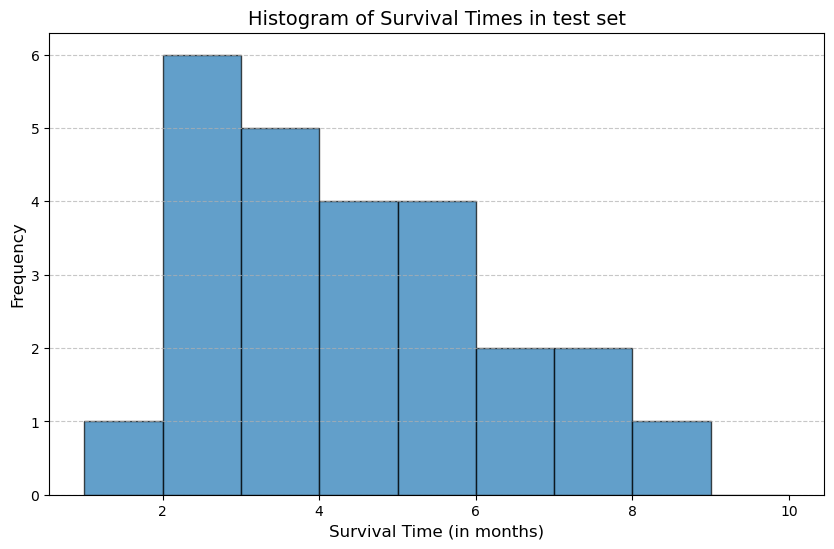

In [125]:
survival_times = y_test["SurvivalTime"]

plt.figure(figsize=(10, 6))
plt.hist(survival_times, bins=np.arange(1, max(survival_times) + 2), edgecolor='black', alpha=0.7)
plt.title('Histogram of Survival Times in test set', fontsize=14)
plt.xlabel('Survival Time (in months)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The mean survival time in the training set is 4.49 months
The mean survival time in the test set is 4.38 months


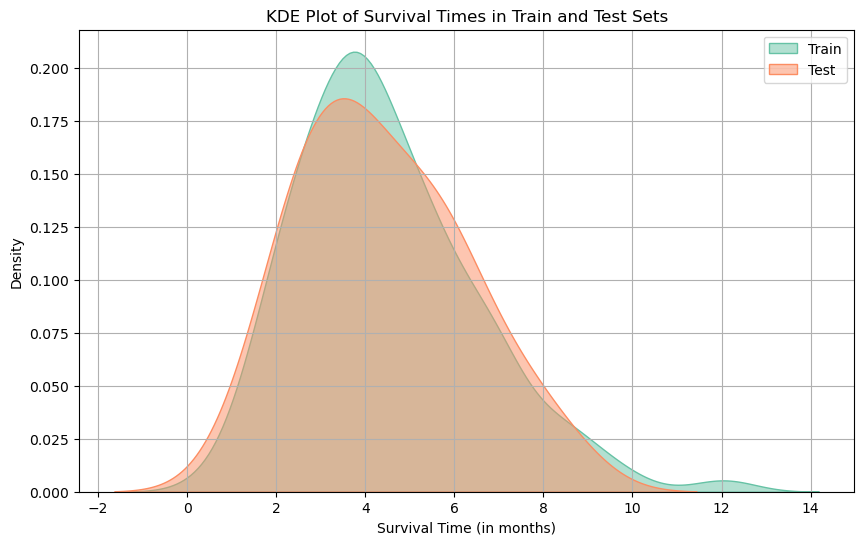

In [126]:
survival_train = y_train["SurvivalTime"]
survival_test = y_test["SurvivalTime"]

# Compute and print mean survival times
print(f"The mean survival time in the training set is {survival_train.mean():.2f} months")
print(f"The mean survival time in the test set is {survival_test.mean():.2f} months")

# Create KDE plot
palette = sns.color_palette("Set2")
plt.figure(figsize=(10, 6))
sns.kdeplot(survival_train, label="Train", fill=True, alpha=0.5, color=palette[0])
sns.kdeplot(survival_test, label="Test", fill=True, alpha=0.5, color=palette[1])
plt.legend()
plt.title("KDE Plot of Survival Times in Train and Test Sets")
plt.xlabel("Survival Time (in months)")
plt.ylabel("Density")
plt.grid(True)
plt.show()

In [127]:
# Merge both sets
X_train = pd.concat([X_train, X_train_NaN])
y_train = pd.concat([y_train, y_train_NaN])
X_test = pd.concat([X_test, X_test_NaN])
y_test = pd.concat([y_test, y_test_NaN])

# Save this files in disk to be reused later
X_train.to_csv('../data/X_train.csv', index=False)
X_test.to_csv('../data/X_test.csv', index=False)
y_train.to_csv('../data/y_train.csv', index=False)
y_test.to_csv('../data/y_test.csv', index=False)

#### Dropping the columns with missing values

In [128]:
X_train_reduced = X_train.drop(columns=missing_columns)
X_test_reduced = X_test.drop(columns=missing_columns)

In [129]:
# Number of NaN's in y_train and y_test
num_nan_y_train = y_train['SurvivalTime'].isna().sum()
num_nan_y_test = y_test['SurvivalTime'].isna().sum()

# Number of censored rows in y_train and y_test
num_censored_y_train = y_train['Censored'].sum()
num_censored_y_test = y_test['Censored'].sum()

print(f"Number of NaN's in y_train: {num_nan_y_train}")
print(f"Number of NaN's in y_test: {num_nan_y_test}")
print(f"Number of censored rows in y_train: {num_censored_y_train}")
print(f"Number of censored rows in y_test: {num_censored_y_test}")

Number of NaN's in y_train: 144
Number of NaN's in y_test: 16
Number of censored rows in y_train: 71
Number of censored rows in y_test: 8


In [130]:
train_mask = y_train["Censored"] == 0
X_train_filtered = X_train_reduced[train_mask]
y_train_filtered = y_train[train_mask]

test_mask = y_test["Censored"] == 0
X_test_filtered = X_test_reduced[test_mask]
y_test_filtered = y_test[test_mask]

In [131]:
# Number of NaN's in y_train and y_test
num_nan_y_train = y_train_filtered['SurvivalTime'].isna().sum()
num_nan_y_test = y_test_filtered['SurvivalTime'].isna().sum()

# Number of censored rows in y_train and y_test
num_censored_y_train = y_train_filtered['Censored'].sum()
num_censored_y_test = y_test_filtered['Censored'].sum()

print(f"Number of NaN's in y_train: {num_nan_y_train}")
print(f"Number of NaN's in y_test: {num_nan_y_test}")
print(f"Number of censored rows in y_train: {num_censored_y_train}")
print(f"Number of censored rows in y_test: {num_censored_y_test}")

Number of NaN's in y_train: 144
Number of NaN's in y_test: 16
Number of censored rows in y_train: 0
Number of censored rows in y_test: 0


In [132]:
X_train_filtered = X_train_filtered[y_train_filtered["SurvivalTime"].notna()]
y_train_filtered = y_train_filtered[y_train_filtered["SurvivalTime"].notna()]

X_test_filtered = X_test_filtered[y_test_filtered["SurvivalTime"].notna()]
y_test_filtered = y_test_filtered[y_test_filtered["SurvivalTime"].notna()]

In [133]:
# Number of NaN's in y_train and y_test
num_nan_y_train = y_train_filtered['SurvivalTime'].isna().sum()
num_nan_y_test = y_test_filtered['SurvivalTime'].isna().sum()

# Number of censored rows in y_train and y_test
num_censored_y_train = y_train_filtered['Censored'].sum()
num_censored_y_test = y_test_filtered['Censored'].sum()

print(f"Number of NaN's in y_train: {num_nan_y_train}")
print(f"Number of NaN's in y_test: {num_nan_y_test}")
print(f"Number of censored rows in y_train: {num_censored_y_train}")
print(f"Number of censored rows in y_test: {num_censored_y_test}")

Number of NaN's in y_train: 0
Number of NaN's in y_test: 0
Number of censored rows in y_train: 0
Number of censored rows in y_test: 0


The mean survival time in the training set is 4.52 months
The mean survival time in the test set is 4.38 months


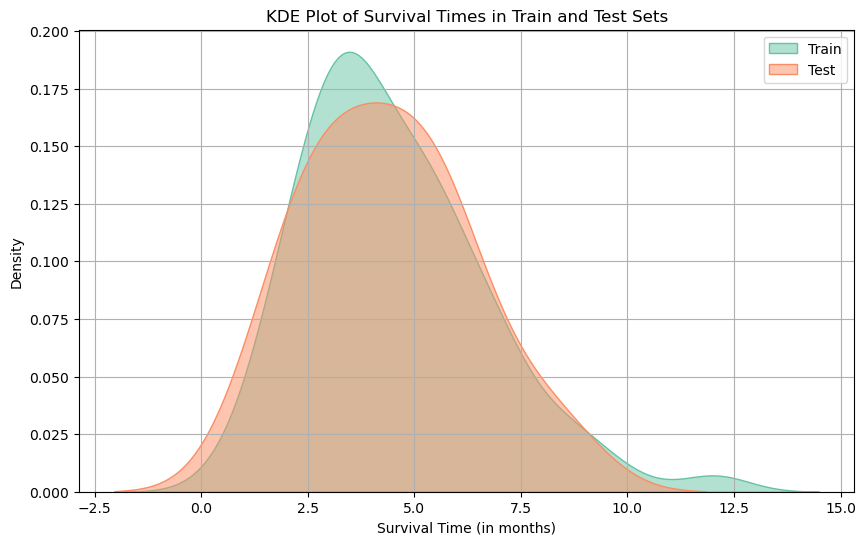

In [134]:
survival_train = y_train_filtered["SurvivalTime"]
survival_test = y_test_filtered["SurvivalTime"]

# Compute and print mean survival times
print(f"The mean survival time in the training set is {survival_train.mean():.2f} months")
print(f"The mean survival time in the test set is {survival_test.mean():.2f} months")

# Create KDE plot
palette = sns.color_palette("Set2")
plt.figure(figsize=(10, 6))
sns.kdeplot(survival_train, label="Train", fill=True, alpha=0.5, color=palette[0])
sns.kdeplot(survival_test, label="Test", fill=True, alpha=0.5, color=palette[1])
plt.legend()
plt.title("KDE Plot of Survival Times in Train and Test Sets")
plt.xlabel("Survival Time (in months)")
plt.ylabel("Density")
plt.grid(True)
plt.show()

### Task 1.2 - Learn the baseline model

cMSE (equivalent to MSE for non-censored data): 4.445810875145208


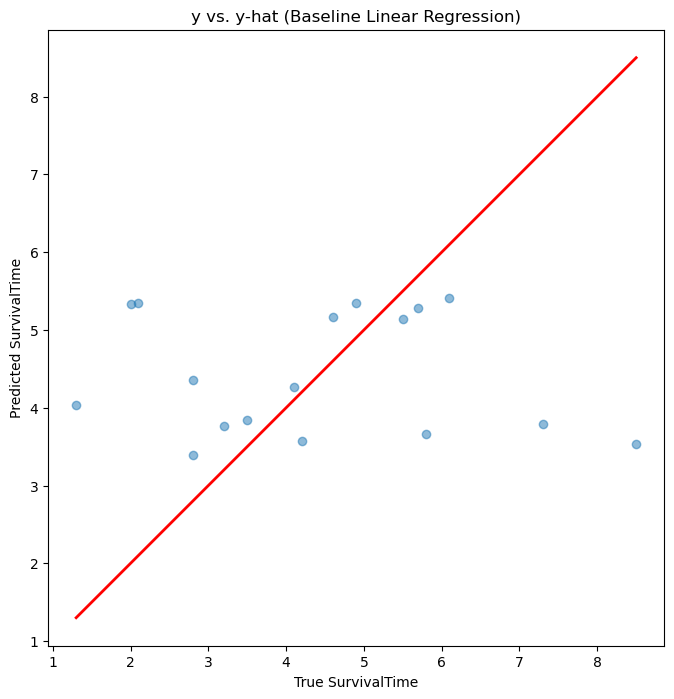

In [135]:
baseline_model = create_baseline_model(X_train_filtered, y_train_filtered["SurvivalTime"])
save_model(baseline_model, "baseline_reduced_features")
y_pred_baseline = baseline_model.predict(X_test_filtered)

cMSE_baseline = cMSE_error(y_test_filtered["SurvivalTime"], y_pred_baseline, y_test_filtered["Censored"])
print(f"cMSE (equivalent to MSE for non-censored data): {cMSE_baseline}")

# # Plot y vs. y-hat
plot_y_yhat(y_test_filtered["SurvivalTime"], y_pred_baseline, plot_title="y vs. y-hat (Baseline Linear Regression)")
plt.show()

In [136]:
baseline = ("Baseline (Linear Regression)", y_test_filtered["SurvivalTime"], y_pred_baseline, y_test_filtered["Censored"])
comparison_df = compare_models([baseline])
comparison_df.T

,Max Error,Min Error,Mean Error,Std Dev of Error,cMSE
Baseline (Linear Regression),4.961072,0.171241,1.544248,2.107924,4.445811


##### Kaggle Prediction

In [59]:
kaggleDF_clean = kaggleDF.drop(columns=missing_columns)
KaggleSubmission = baseline_model.predict(kaggleDF_clean)
create_submission_csv(KaggleSubmission, "baseline_submission_09.csv")

CSV file 'baseline_submission_09.csv' has been created.


### Task 1.3 - Learn with the cMSE

Compute the expression of the derivative of the cMSE loss, where it is defined. Write your computations on the slides (can be a photo of handwritten math).    
Now your training set will include the censored data that is not missing.

#### Derivative of Gradient for Loss Function

The loss function is defined as:

$$
L(\alpha) = \frac{1}{N} \sum_{i=1}^{N} \Big( (1 - c)(y_i - \hat{y}_i)^2 + c \max(0, y_i - \hat{y}_i)^2 \Big)
$$

where:
$$
\hat{y}_i = X_i^\top \alpha \text{ is the predicted values vector}
$$

$$
X \in \mathbb{R}^{d \times N} \text{ is the feature matrix.}
$$

$$
\alpha \in \mathbb{R}^d \text{ is the weight vector.}
$$
$$
y \in \mathbb{R}^N \text{is the target vector.}
$$

#### Compute the Derivative of the Loss function

$$
\frac{\partial L}{\partial \alpha} = \frac{1}{N} \sum_{i=1}^N 
\begin{cases} 
2(y_i - X_i^\top \alpha)X_i, & \text{if } y_i - X_i^\top \alpha > 0 \\
2(1 - c)(y_i - X_i^\top \alpha)X_i, & \text{if } y_i - X_i^\top \alpha \leq 0
\end{cases}
$$

In [153]:
def gradient_descent(X, y, c, iterations=1000, learning_rate=0.01, 
                     regularization=None, alpha=0.1, threshold=1e-6): 
    
    weights = np.random.rand(X.shape[1]) * 0.01  
    losses = []

    for i in range(iterations):
        # Compute predictions
        y_hat = X @ weights

        # Calculate cMSE loss
        loss = cMSE_error(y, y_hat, c)  
        losses.append(loss)

        # Check for convergence
        if i > 0 and abs(losses[-2] - losses[-1]) < threshold:  
            print(f"Convergence reached at iteration {i+1} with loss change below threshold.")
            break

        # Compute gradient
        grad_err = gradient_cMSE_error(y, y_hat, c, X)
        grad = -grad_err
        
        # Apply regularization
        if regularization == 'ridge':
            grad += 2 * alpha * weights  # Ridge (L2)
        elif regularization == 'lasso':
            grad += alpha * np.sign(weights)  # Lasso (L1)

        # Update weights
        weights -= learning_rate * grad

        # Print progress every 100 iterations
        if i % 100 == 0:
            print(f"Iteration {i+1}: Loss = {loss}")

    return weights, losses

In [154]:
# Remove rows where the label is NaN in the training set
gd_X_train_reduced = X_train_reduced[y_train["SurvivalTime"].notna()]
gd_y_train_reduced = y_train[y_train["SurvivalTime"].notna()]

# Remove rows where the label is NaN in the test set
gd_X_test_reduced = X_test_reduced[y_test["SurvivalTime"].notna()]
gd_y_test_reduced = y_test[y_test["SurvivalTime"].notna()]

In [155]:
GDmodel_ridge = CustomLinearRegression(iterations=10000000, learning_rate=0.0000001, regularization='ridge', alpha=0.1)
GDmodel_ridge.fit(gd_X_train_reduced, gd_y_train_reduced)
save_model(GDmodel_ridge, "Gradient_Descent_model")

Iteration 1: Loss = 21.144973471424752
Iteration 101: Loss = 18.50404548979303
Iteration 201: Loss = 16.282599191304506
Iteration 301: Loss = 14.41400413386977
Iteration 401: Loss = 12.841543434883123
Iteration 501: Loss = 11.516382734442832
Iteration 601: Loss = 10.397037234427241
Iteration 701: Loss = 9.449184985029705
Iteration 801: Loss = 8.64534016962314
Iteration 901: Loss = 7.962389442364882
Iteration 1001: Loss = 7.381384654622459
Iteration 1101: Loss = 6.886361907461277
Iteration 1201: Loss = 6.463808768682571
Iteration 1301: Loss = 6.10255136108161
Iteration 1401: Loss = 5.793499470471924
Iteration 1501: Loss = 5.528781147187838
Iteration 1601: Loss = 5.301795459967221
Iteration 1701: Loss = 5.106991940870339
Iteration 1801: Loss = 4.939747220637482
Iteration 1901: Loss = 4.795932751677721
Iteration 2001: Loss = 4.67186766013691
Iteration 2101: Loss = 4.564749000428394
Iteration 2201: Loss = 4.472232679171563
Iteration 2301: Loss = 4.39218465132066
Iteration 2401: Loss = 4.32

In [156]:
y_pred_gd_ridge = GDmodel_ridge.predict(gd_X_test_reduced)
gd_cMSE = cMSE_error(gd_y_test_reduced["SurvivalTime"], y_pred_gd_ridge, gd_y_test_reduced["Censored"])
print(f"cMSE for Gradient Descent: {gd_cMSE}")
print(f"cMSE for the Baseline Model: {cMSE_baseline}")

cMSE for Gradient Descent: 3.4384902021513564
cMSE for the Baseline Model: 4.445810875145208


In [157]:
create_submission_csv(GDmodel_ridge.predict(kaggleDF_clean), "cMSE-baseline_submission-01.csv")

CSV file 'cMSE-baseline_submission-01.csv' has been created.


In [158]:
GDmodel_lasso = CustomLinearRegression(iterations=10000000, learning_rate=0.0000001, regularization='lasso', alpha=0.1)
GDmodel_lasso.fit(gd_X_train_reduced, gd_y_train_reduced)

y_pred_gd_lasso = GDmodel_lasso.predict(gd_X_test_reduced)
gd_cMSE_lasso = cMSE_error(gd_y_test_reduced["SurvivalTime"], y_pred_gd_lasso, gd_y_test_reduced["Censored"])
print(f"cMSE for Gradient Descent with Lasso: {gd_cMSE_lasso}")

Iteration 1: Loss = 20.448202743898946
Iteration 101: Loss = 17.91794725078285
Iteration 201: Loss = 15.789550696439086
Iteration 301: Loss = 13.999167076753956
Iteration 401: Loss = 12.491981764360768
Iteration 501: Loss = 11.221159627313892
Iteration 601: Loss = 10.146890151818365
Iteration 701: Loss = 9.236924844199232
Iteration 801: Loss = 8.464777504410678
Iteration 901: Loss = 7.808531313186601
Iteration 1001: Loss = 7.250033983868667
Iteration 1101: Loss = 6.77400982670752
Iteration 1201: Loss = 6.3674455949680775
Iteration 1301: Loss = 6.0197886962288205
Iteration 1401: Loss = 5.72228468749818
Iteration 1501: Loss = 5.4673816925646435
Iteration 1601: Loss = 5.248730068790987
Iteration 1701: Loss = 5.06105888925722
Iteration 1801: Loss = 4.899887337837325
Iteration 1901: Loss = 4.761138329740138
Iteration 2001: Loss = 4.641382697474256
Iteration 2101: Loss = 4.537978001970737
Iteration 2201: Loss = 4.448624648712411
Iteration 2301: Loss = 4.371265259520252
Iteration 2401: Loss =

In [159]:
GDmodel = CustomLinearRegression(iterations=10000000, learning_rate=0.0000001, regularization=None, alpha=0.1)
GDmodel.fit(gd_X_train_reduced, gd_y_train_reduced)

y_pred_gd = GDmodel.predict(gd_X_test_reduced)
gd_cMSE = cMSE_error(gd_y_test_reduced["SurvivalTime"], y_pred_gd, gd_y_test_reduced["Censored"])
print(f"cMSE for Gradient Descent: {gd_cMSE}")

Iteration 1: Loss = 23.723339391016026
Iteration 101: Loss = 20.672702033397776
Iteration 201: Loss = 18.106620004938463
Iteration 301: Loss = 15.94812769629621
Iteration 401: Loss = 14.132482606027732
Iteration 501: Loss = 12.604280975562025
Iteration 601: Loss = 11.31604590777669
Iteration 701: Loss = 10.227356764403737
Iteration 801: Loss = 9.305274638738398
Iteration 901: Loss = 8.522996638002686
Iteration 1001: Loss = 7.858231567008911
Iteration 1101: Loss = 7.2925592350855615
Iteration 1201: Loss = 6.810466964987293
Iteration 1301: Loss = 6.398812364478027
Iteration 1401: Loss = 6.0468358517714575
Iteration 1501: Loss = 5.745665686161973
Iteration 1601: Loss = 5.4876563518278845
Iteration 1701: Loss = 5.266375591058915
Iteration 1801: Loss = 5.076461525524687
Iteration 1901: Loss = 4.913390966905966
Iteration 2001: Loss = 4.7730869027237235
Iteration 2101: Loss = 4.6520132890053345
Iteration 2201: Loss = 4.547478092997898
Iteration 2301: Loss = 4.457174889293463
Iteration 2401: L

In [160]:
df_GD = compare_models([("Baseline (Linear Regression)", y_test_filtered["SurvivalTime"], y_pred_baseline, y_test_filtered["Censored"]),
                        ("Gradient Descent", gd_y_test_reduced["SurvivalTime"], y_pred_gd, gd_y_test_reduced["Censored"]),
                        ("Gradient Descent (Ridge)", gd_y_test_reduced["SurvivalTime"], y_pred_gd_ridge, gd_y_test_reduced["Censored"]),
                        ("Gradient Descent (Lasso)", gd_y_test_reduced["SurvivalTime"], y_pred_gd_lasso, gd_y_test_reduced["Censored"])])

df_GD.T

,Max Error,Min Error,Mean Error,Std Dev of Error,cMSE
Baseline (Linear Regression),4.961072,0.171241,1.544248,2.107924,4.445811
Gradient Descent,4.420794,0.031866,1.590147,1.919863,3.438291
Gradient Descent (Ridge),4.419305,0.031219,1.590229,1.919965,3.438490
Gradient Descent (Lasso),4.423260,0.031948,1.589140,1.919284,3.435690


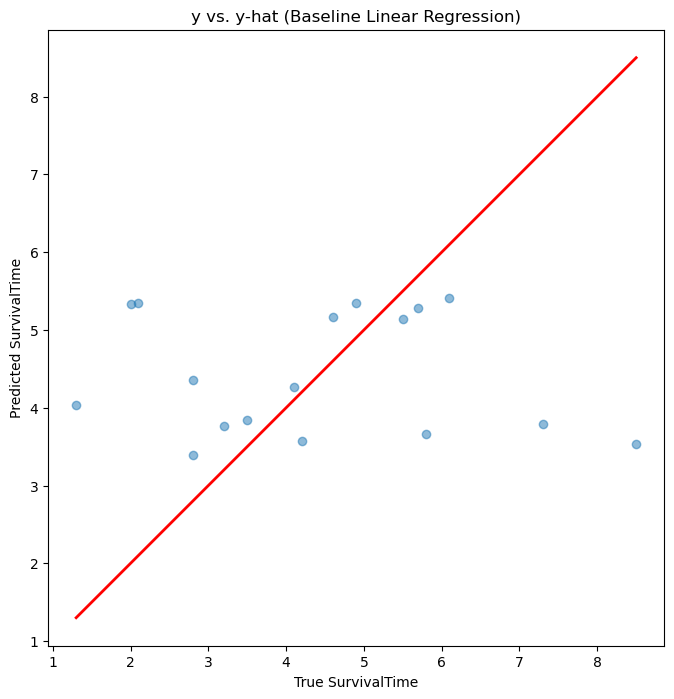

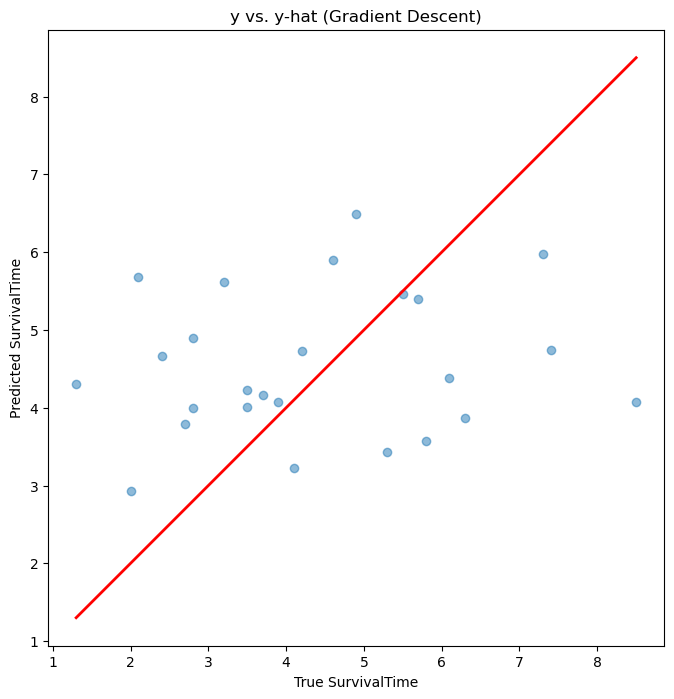

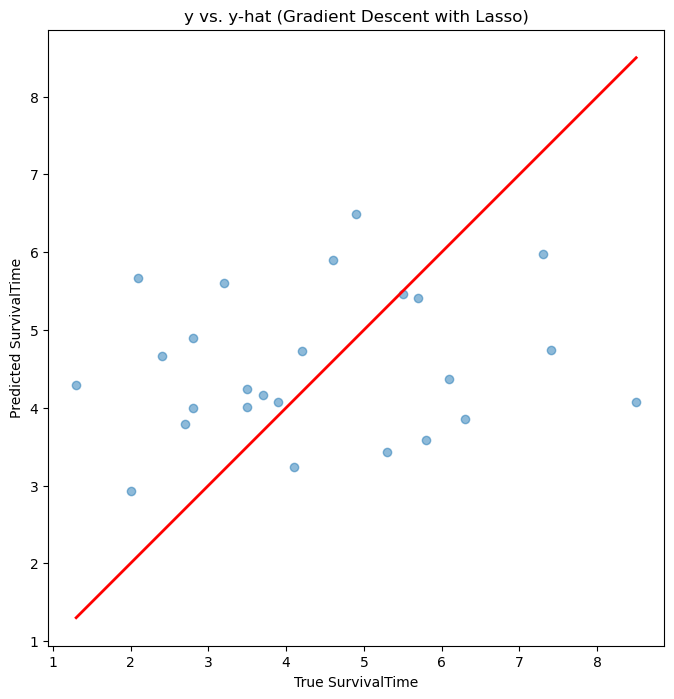

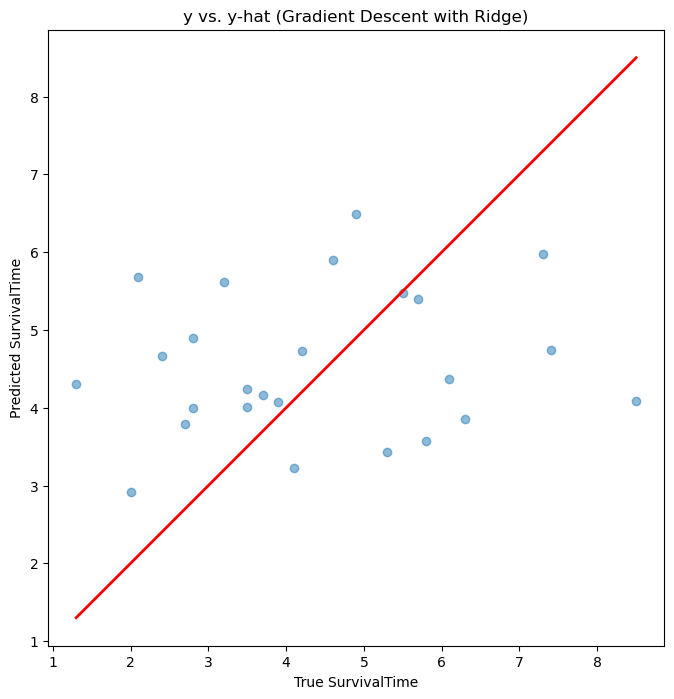

In [161]:
plot_y_yhat(y_test_filtered["SurvivalTime"], y_pred_baseline, plot_title="y vs. y-hat (Baseline Linear Regression)")
plot_y_yhat(gd_y_test_reduced["SurvivalTime"], y_pred_gd, plot_title="y vs. y-hat (Gradient Descent)")
plot_y_yhat(gd_y_test_reduced["SurvivalTime"], y_pred_gd_lasso, plot_title="y vs. y-hat (Gradient Descent with Lasso)")
plot_y_yhat(gd_y_test_reduced["SurvivalTime"], y_pred_gd_ridge, plot_title="y vs. y-hat (Gradient Descent with Ridge)")